In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from pathlib import Path

from CompLex import load_dataset, preprocess_data, tokenize_complex_dataset, create_base_model, apply_lora, create_trainer_complex
from train import run_single_training
from schema import TrainingConfig, TrainingTask

In [14]:

config = TrainingConfig(
    task=TrainingTask.CompLexV1,
    rank=16,
    alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.1,
    learning_rate=2e-4,
    batch_size=8,
    num_epochs=3,
    max_input_length=128
)

In [15]:
model, tokenizer = create_base_model()
model = apply_lora(model, config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
data = load_dataset()
data = preprocess_data(data)

Filter:   0%|          | 0/9179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9172 [00:00<?, ? examples/s]

Filter:   0%|          | 0/520 [00:00<?, ? examples/s]

In [17]:
trainer, result = run_single_training(
    config=config,
    dataset=data,
    output_dir=None
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with config: task=<TrainingTask.CompLexV1: 1> rank=16 alpha=16 target_modules=['query', 'key', 'value'] lora_dropout=0.1 max_input_length=128 num_epochs=3 learning_rate=0.0002 batch_size=8
Creating model with LoRA adapters...
Tokenizing dataset...


Map:   0%|          | 0/9172 [00:00<?, ? examples/s]

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

Training...


Epoch,Training Loss,Validation Loss,Model Preparation Time,Pearson R
1,0.010900,0.007848,0.003200,0.801593
2,0.008700,0.007726,0.003200,0.812564
3,0.007200,0.007272,0.003200,0.819369


In [ ]:
# Save model
MODEL_PATH = Path.home() / "models/lexetta/complex" 

trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

# Visualize Training progress

In [18]:
from utils.draw import draw_loss_curves

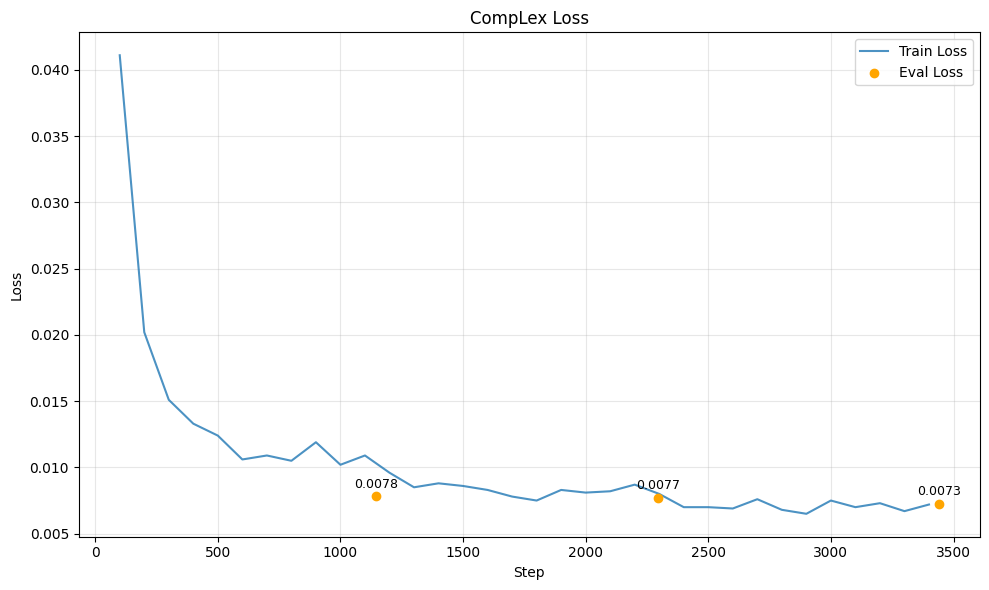

In [20]:
draw_loss_curves(result.metrics.logs, title="CompLex Loss")